In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm, colormaps
from skimage import measure, morphology

# SeLinCuo

In [18]:
def extract_contour_SLC(img_path, crop_box=None, show=False):
  img = Image.open(img_path).convert('RGB')
  if crop_box:
      box = (crop_box[0] if crop_box[0] else 0,
             crop_box[1] if crop_box[1] else 0,
             crop_box[2] if crop_box[2] else img.width,
             crop_box[3] if crop_box[3] else img.height)
      img = img.crop(box)
  rgb = np.array(img).astype(np.float32)/255
  r = rgb[:, :, 0]
  g = rgb[:, :, 1]
  b = rgb[:, :, 2]

  rgb_sum = r + g + b + 1e-6  # prevent divide-by-zero
  r_norm = r / rgb_sum
  g_norm = g / rgb_sum
  b_norm = b / rgb_sum

  brightness = 0.299 * r + 0.587 * g + 0.114 * b

  water_mask = (
      ((b_norm > 0.32) &        # strong blue channel
      (g_norm > 0.13) & (g_norm < 0.42) &  # moderate green
      (r_norm < 0.31))         # low red
      | (brightness < 0.15) # dark areas
  ) 
  
  clean_mask = morphology.remove_small_objects(water_mask, min_size=500)
  clean_mask = morphology.remove_small_holes(clean_mask, area_threshold=500)

  contours = measure.find_contours(clean_mask, level=0.5)
  largest_contour = max(contours, key=len)

  if show:
    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(clean_mask, cmap='gray')
    ax[1].set_title("Binary Mask")
    ax[1].axis('off')

    ax[2].imshow(rgb, cmap='gray')
    for c in contours:
        plt.plot(c[:, 1], c[:, 0], color='lime', linewidth=2)
        
    ax[2].plot(largest_contour[:, 1], largest_contour[:, 0], color='red', linewidth=2, label='Largest Contour')
    ax[2].set_title("Contours")
    ax[2].axis('off')
    ax[2].legend()
    
    plt.show()
  
  return clean_mask, (largest_contour[:, 1], largest_contour[:, 0])  # x, y coordinates of the contour

### save binary masks

In [19]:
SLC_contours = []
for year in range(1996, 2021):
    img_path = f'SLC/images/SLC_{year}.png'
    mask, contour = extract_contour_SLC(img_path, crop_box=(None, 150, 1100, 1150), show=False)
    # np.save(f'SLC/SLC_mask_{year}.npy', mask)
    SLC_contours.append(contour)

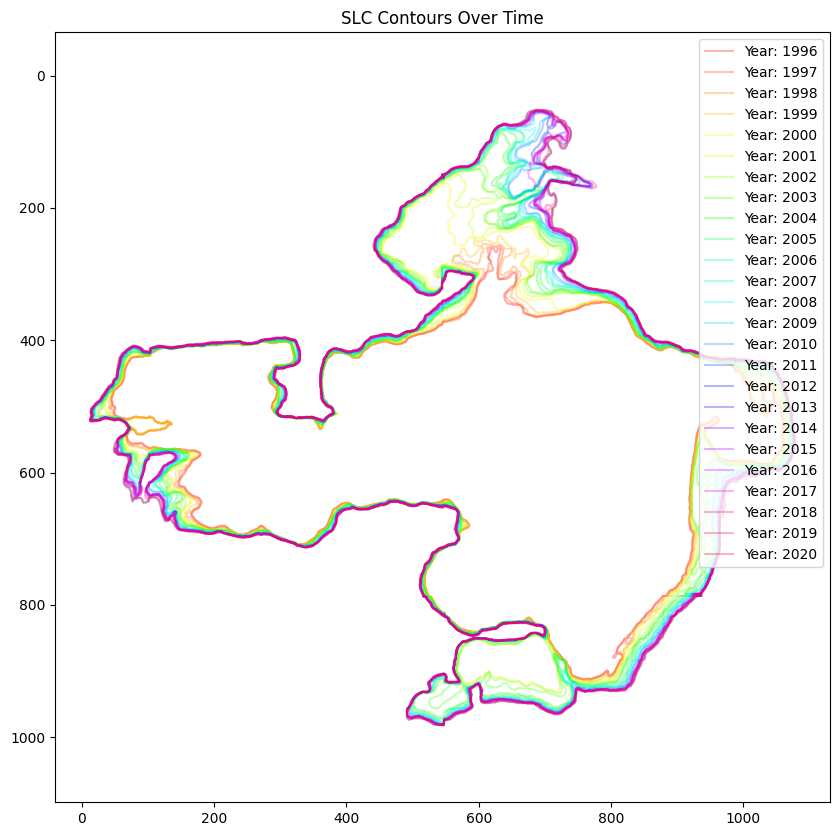

In [27]:
cmap = colormaps['hsv'].resampled(len(SLC_contours))

plt.figure(figsize=(10, 10))
for (i, c) in enumerate(SLC_contours):
  plt.plot(c[0], c[1], color=cmap(i), alpha=0.3, label=f'Year: {1996 + i}')

plt.title('SLC Contours Over Time')
plt.legend()
plt.axis('equal')
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.savefig('SLC_contours_pretty.png', dpi=300, bbox_inches='tight')
plt.show()

# Lake Mead

In [29]:
def extract_contour_mead(img_path, crop_box=None, show=False):
    img = Image.open(img_path).convert("RGB")
    if crop_box:
        box = (crop_box[0] if crop_box[0] else 0,
               crop_box[1] if crop_box[1] else 0,
               crop_box[2] if crop_box[2] else img.width,
               crop_box[3] if crop_box[3] else img.height)
        img = img.crop(box)
        
    rgb = np.array(img).astype(np.float32) / 255
    r,g,b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    
    brightness = 0.299 * r + 0.587 * g + 0.114 * b
    
    water_mask = (
        (brightness < 0.12) |
        ((b > r + 0.08) & 
        (g > r + 0.05))
    )
    
    closed = morphology.closing(water_mask, morphology.disk(2))
    clean_water = morphology.remove_small_objects(closed, min_size=1000)
    clean_water = morphology.remove_small_holes(clean_water, area_threshold=1000)
    
    contours = measure.find_contours(clean_water, 0.5)
    largest_contour = max(contours, key=len)

    if show:
        _, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        ax[1].imshow(clean_water, cmap='gray')
        ax[1].axis('off')

        ax[2].imshow(rgb, cmap='gray')
        for c in contours:
            plt.plot(c[:, 1], c[:, 0], color='lime', linewidth=2)
            
        ax[2].plot(largest_contour[:, 1], largest_contour[:, 0], color='red', linewidth=2, label='Largest Contour')
        ax[2].axis('off')

        plt.show()

    return clean_water, (largest_contour[:, 1], largest_contour[:, 0])  # x, y coordinates of the contour

### save binary masks

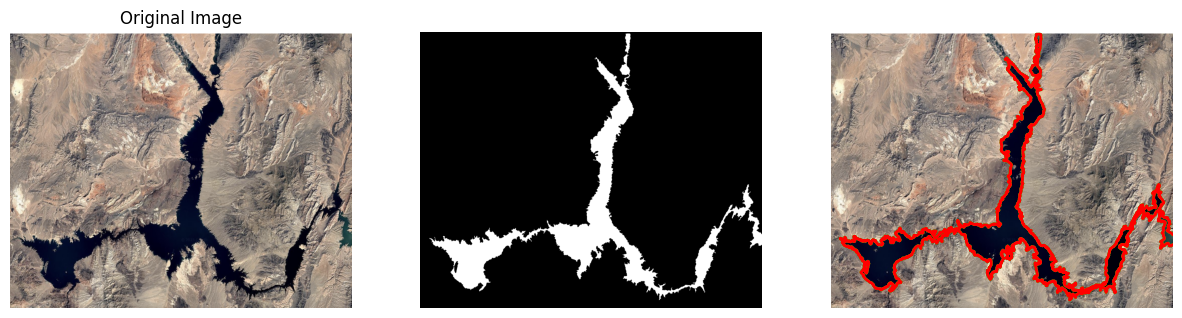

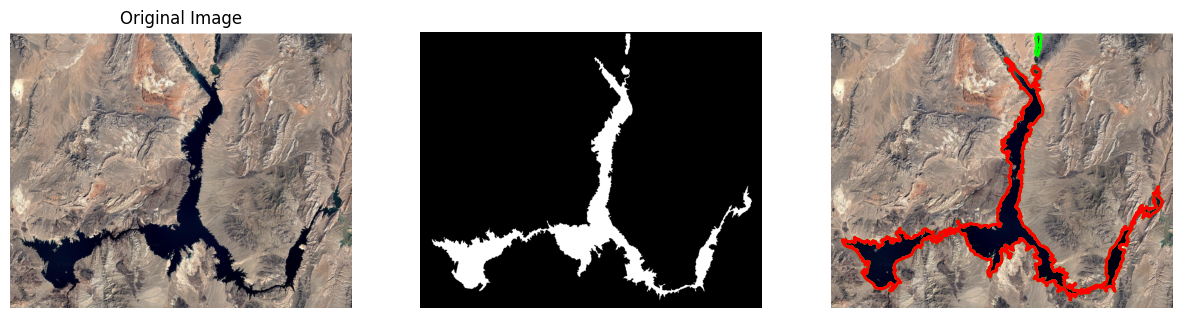

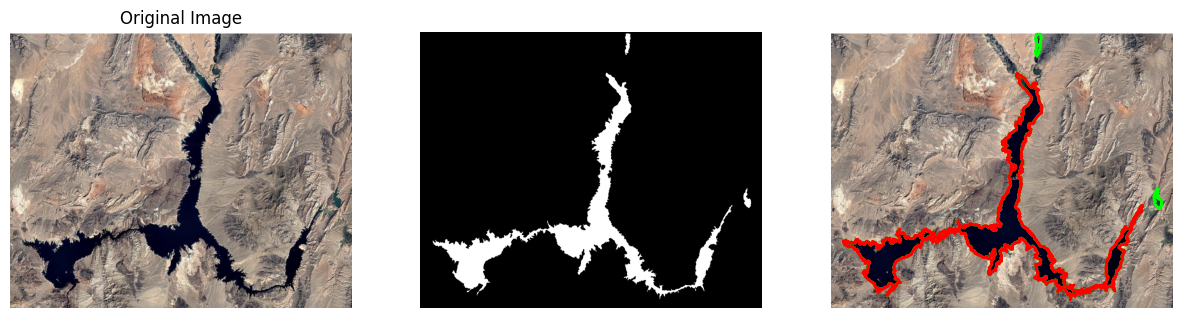

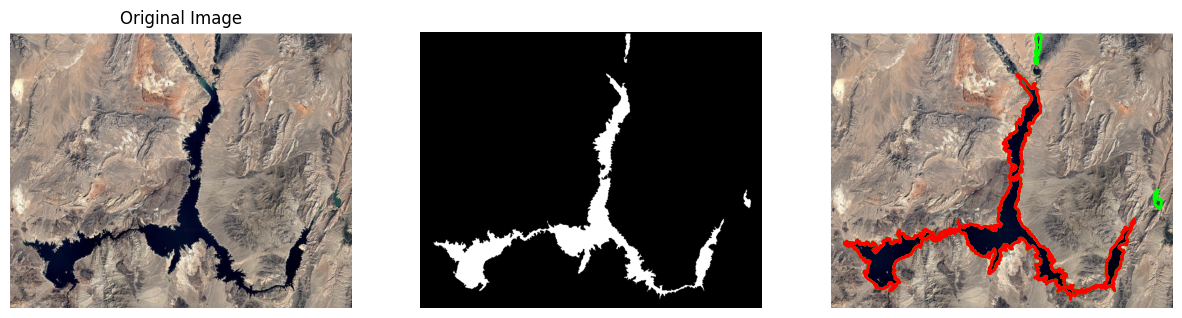

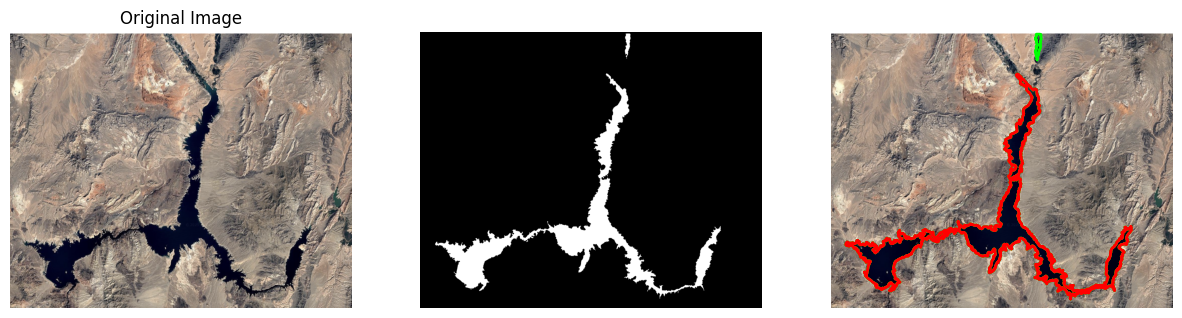

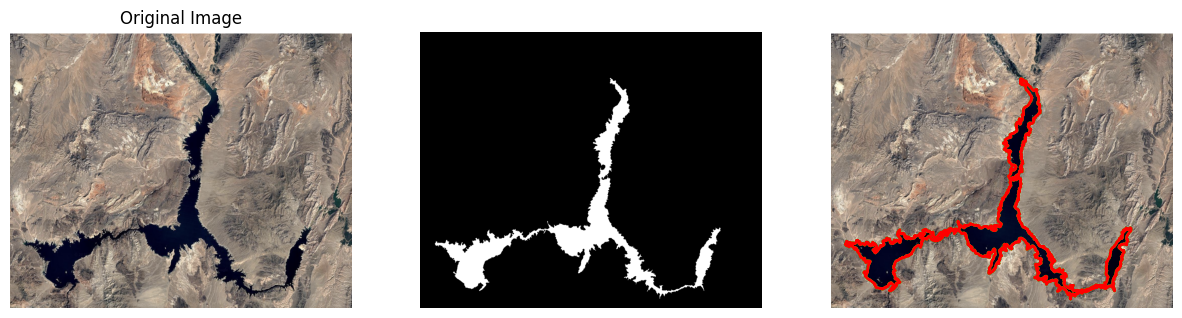

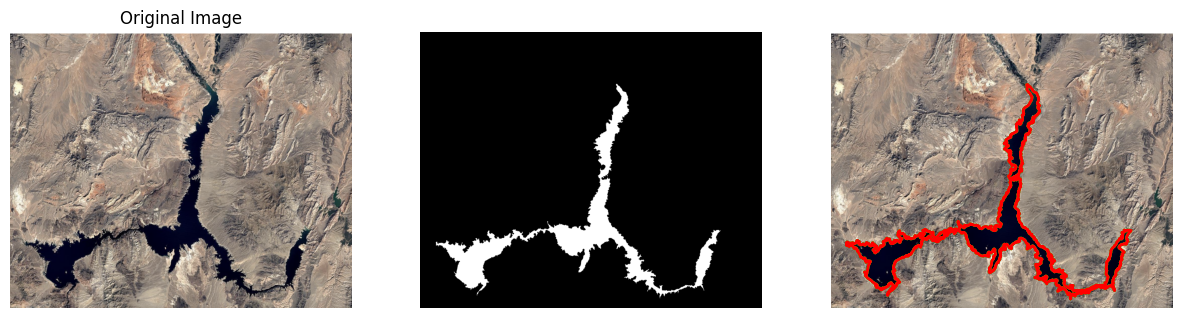

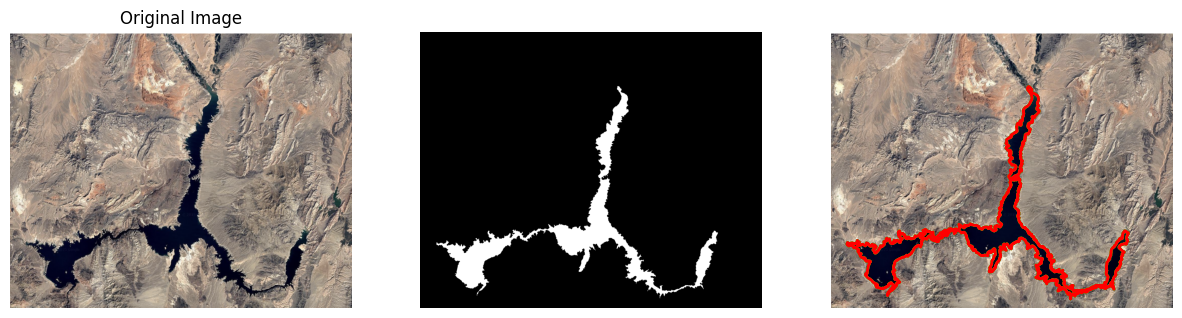

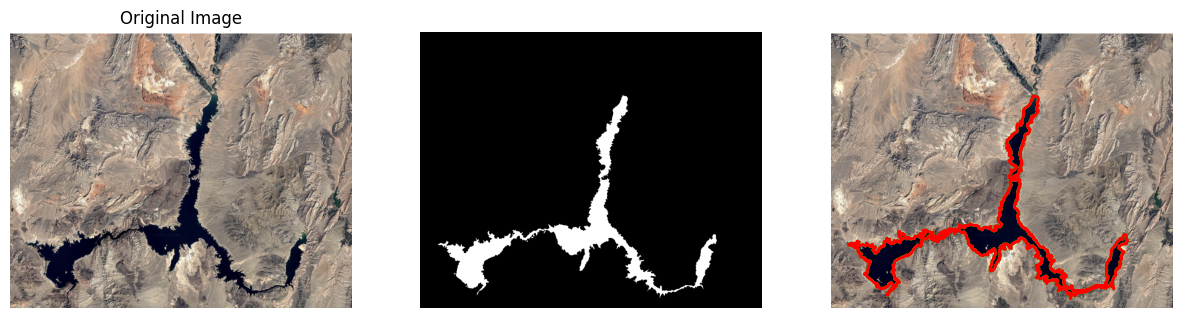

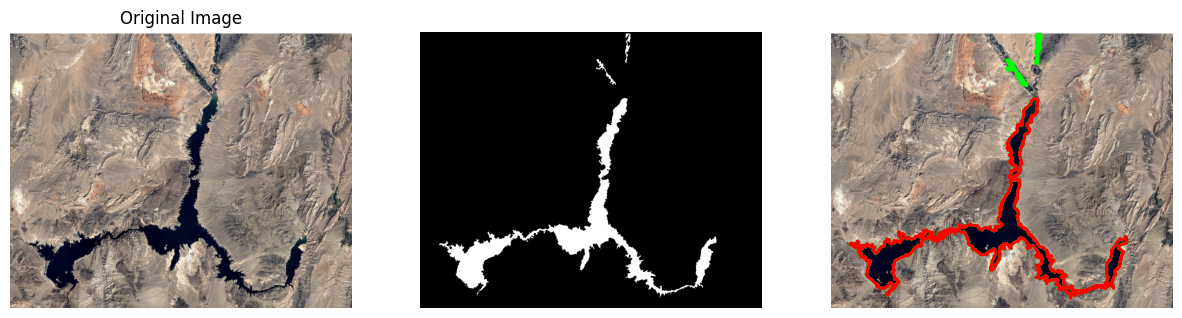

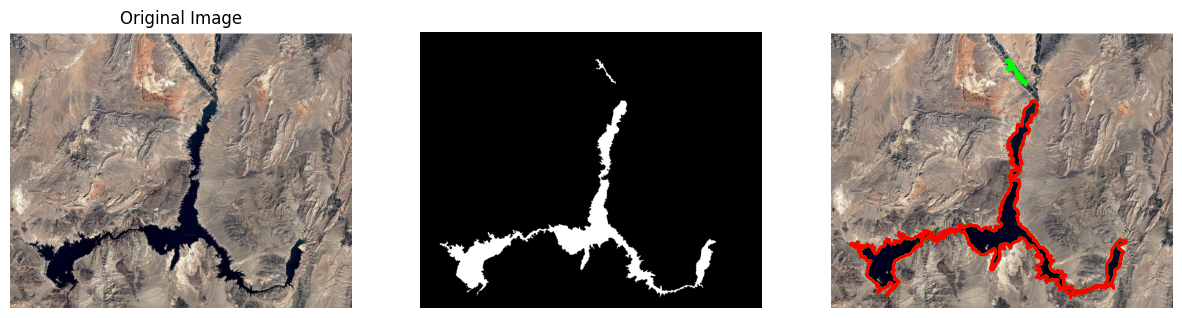

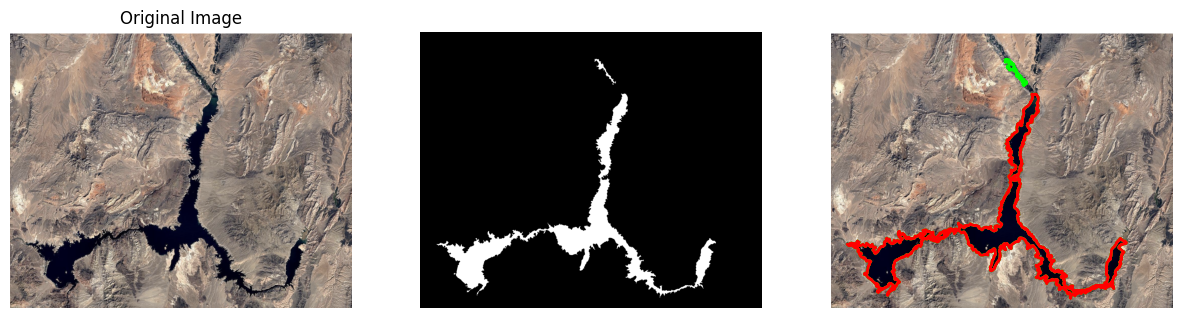

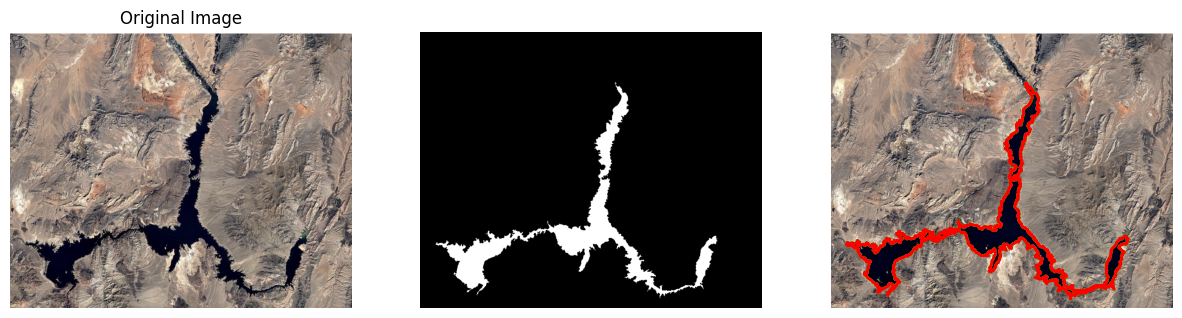

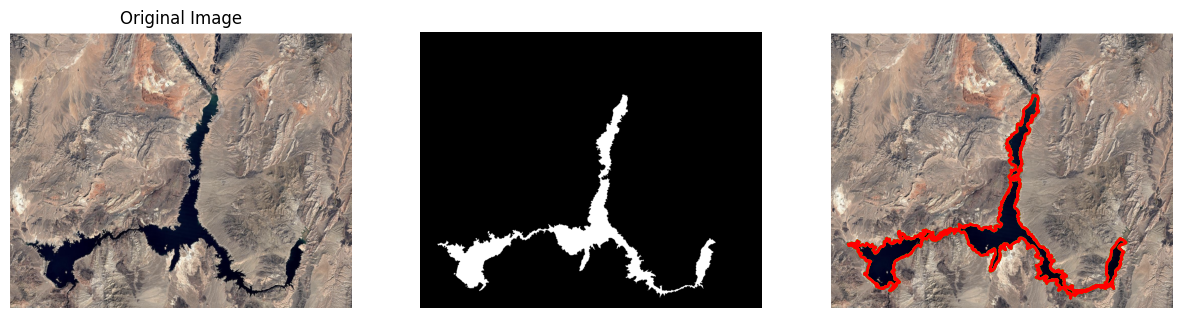

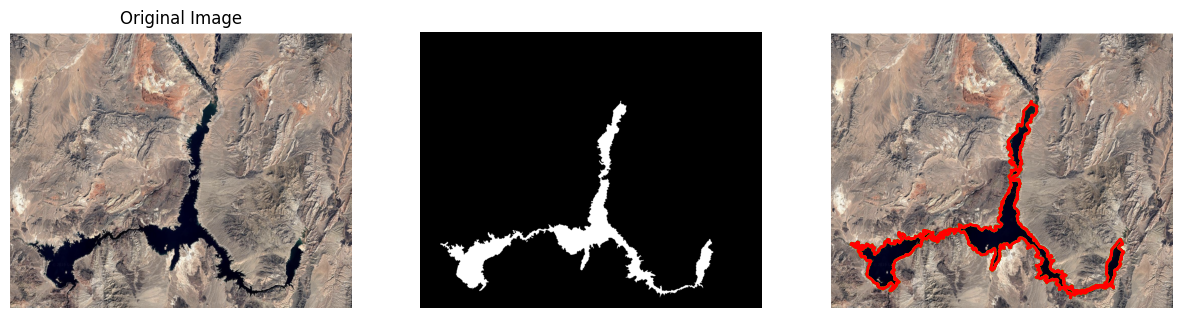

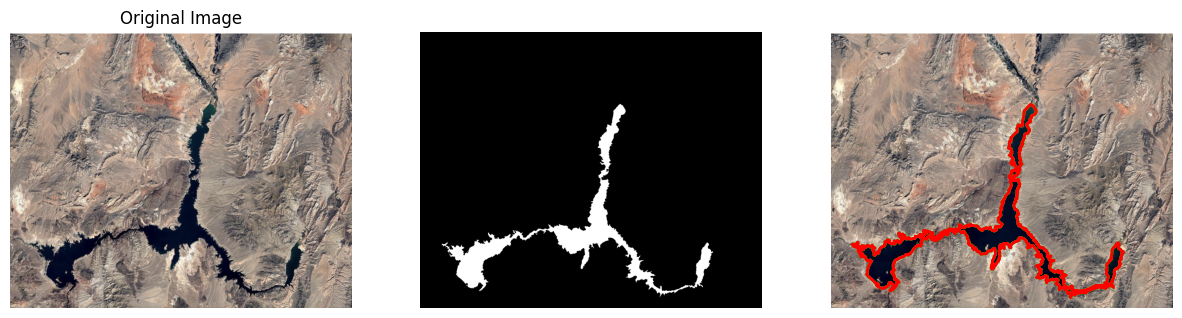

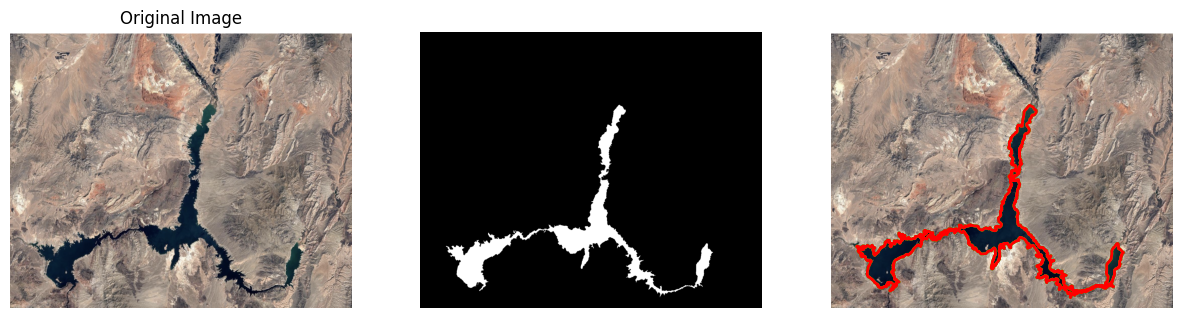

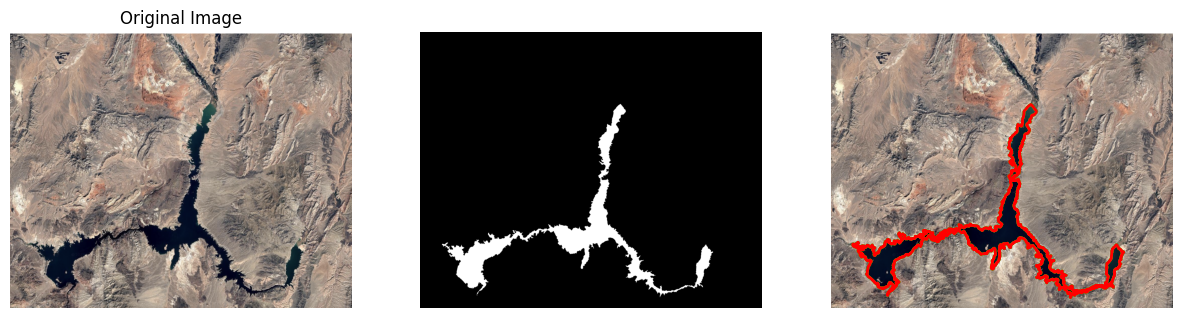

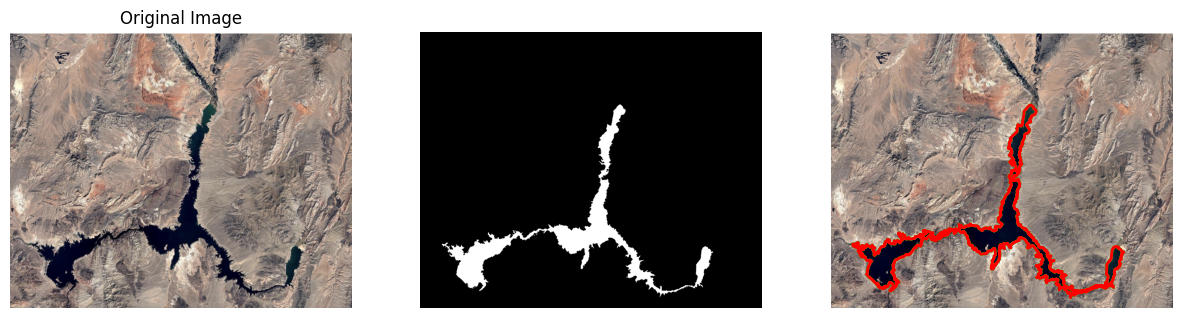

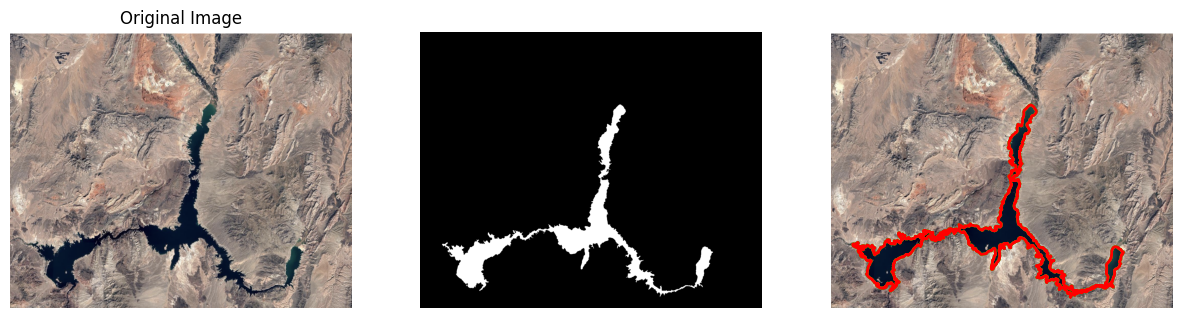

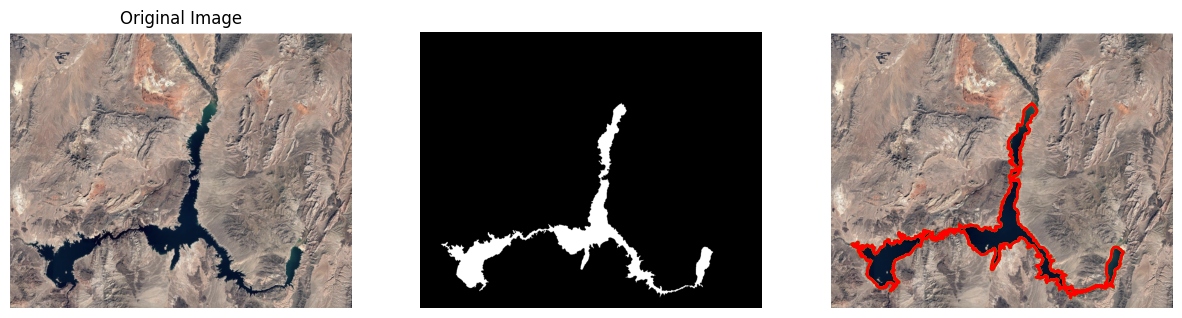

In [33]:
MEAD_contours = []
for year in range(2000, 2021):
    filepath = f"MEAD/images/MEAD_{year}.png"
    mask, contour = extract_contour_mead(filepath, crop_box=(None, 100, None, None), show=True)
    # np.save(f'MEAD/MEAD_mask_{year}.npy', mask)    
    MEAD_contours.append(contour)

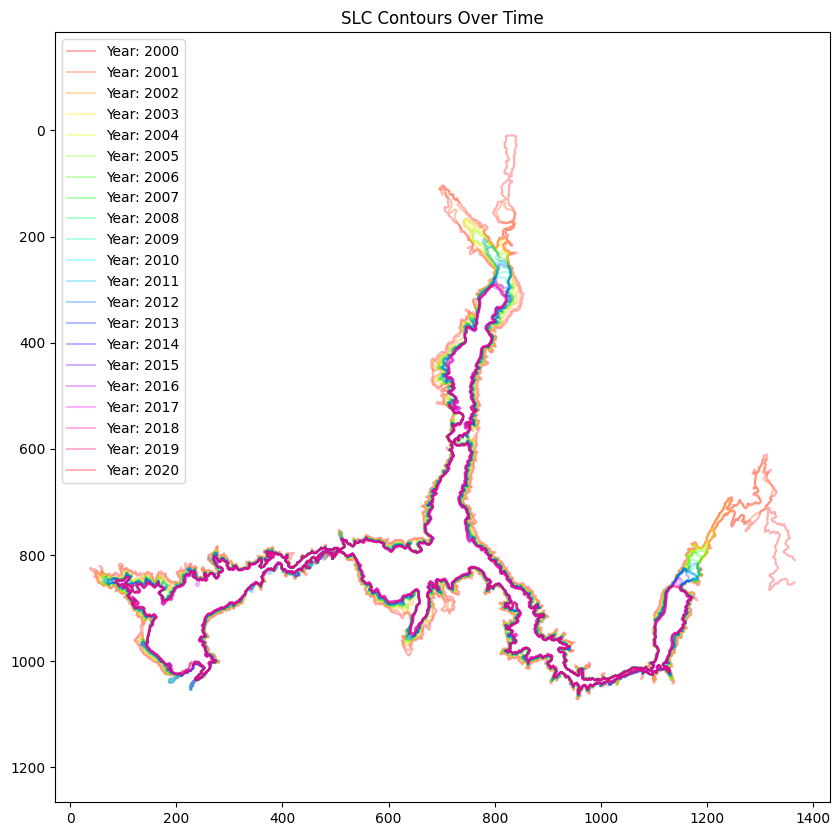

In [34]:
cmap = colormaps['hsv'].resampled(len(MEAD_contours))

plt.figure(figsize=(10, 10))
for (i, c) in enumerate(MEAD_contours):
  plt.plot(c[0], c[1], color=cmap(i), alpha=0.3, label=f'Year: {2000 + i}')

plt.title('SLC Contours Over Time')
plt.legend()
plt.axis('equal')
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.savefig('MEAD_contours_pretty.png', dpi=300, bbox_inches='tight')
plt.show()